# Air quality Analysis

problem statement: Based on the 9 features we have to predict the Air quality.
Dataset:- https://www.kaggle.com/api/v1/datasets/download/mujtabamatin/air-quality-and-pollution-assessment

# Outline

1. Import libraries
2. Helper functions
3. Load data and EDA
4. Data preprocessing
5. Multiple Model building
6. Model Evaluation

## 1. Libraries

In [111]:
# data handling and visulaizing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing
import sklearn
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# model building
from sklearn.linear_model import LinearRegression, LogisticRegression
import sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC



## 2. Helper functions

In [20]:
# Method to return unique values for categorical columns with their count
def count_categorical_values(data):
    agg_val = []
    for col in data.columns:
        if data[col].dtype == "O":
            agg_val.append(data[col].value_counts())
        
    return agg_val

In [36]:
def count_cat_num(data):
    num_col = [col for col in data.columns if data[col].dtype != "O"]
    cat_col = [col for col in data.columns if data[col].dtype == "O"]
    
    print(f"Dataset has {len(num_col)} numerical features with values/value {num_col}")
    print(f"Dataset has {len(cat_col)} categorical features with values/value {cat_col}")

In [44]:
def plot_outliers(data):
    # Select numerical columns
    num_cols = [col for col in data.columns if data[col].dtype != 'O']
    
    # Define the number of rows and columns for the subplot grid
    num_plots = len(num_cols)
    cols_per_row = 4
    rows = (num_plots + cols_per_row - 1) // cols_per_row  # Calculate required rows
    
    # Create subplots
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(20, rows * 5))  # Adjust figsize for better display
    axes = axes.flatten()  # Flatten the 2D axes array to 1D for easier indexing
    
    # Plot each boxplot
    for idx, col in enumerate(num_cols):
        sns.boxplot(x=data[col], ax=axes[idx])
        axes[idx].set_title(f"Boxplot of {col}")
        axes[idx].set_xlabel("")
    
    # Hide any unused subplots
    for idx in range(num_plots, len(axes)):
        axes[idx].axis("off")
    
    plt.tight_layout()
    plt.show()

In [47]:
def plot_histograms(data):
    # Select numerical columns
    num_cols = [col for col in data.columns if data[col].dtype != 'O']
    
    # Define the number of rows and columns for the subplot grid
    num_plots = len(num_cols)
    cols_per_row = 4
    rows = (num_plots + cols_per_row - 1) // cols_per_row  # Calculate required rows
    
    # Create subplots
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(20, rows * 5))  # Adjust figsize for better display
    axes = axes.flatten()  # Flatten the 2D axes array to 1D for easier indexing
    
    # Plot each histogram
    for idx, col in enumerate(num_cols):
        sns.histplot(data[col], ax=axes[idx], bins=30, kde=True, color='blue')  # Histogram with KDE overlay
        axes[idx].set_title(f"Histogram of {col}")
        axes[idx].set_xlabel("")
    
    # Hide any unused subplots
    for idx in range(num_plots, len(axes)):
        axes[idx].axis("off")
    
    plt.tight_layout()
    plt.show()


In [48]:
def plot_categorical(data):
    # Select categorical columns
    cat_cols = [col for col in data.columns if data[col].dtype == 'O']
    
    # Create subplots
    num_plots = len(cat_cols)
    cols_per_row = 4
    rows = (num_plots + cols_per_row - 1) // cols_per_row
    
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(20, rows * 5))
    axes = axes.flatten()
    
    for idx, col in enumerate(cat_cols):
        sns.countplot(x=data[col], ax=axes[idx], palette='viridis')  # Bar plot for categorical data
        axes[idx].set_title(f"Countplot of {col}")
    
    for idx in range(num_plots, len(axes)):
        axes[idx].axis("off")
    
    plt.tight_layout()
    plt.show()

In [46]:
def remove_outliers(data):
    for col in [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]:
        Q1 = data[col].quantile(0.25)  # 1st quartile
        Q3 = data[col].quantile(0.75)  # 3rd quartile
        IQR = Q3 - Q1  # Interquartile range

        # Proceed only if IQR > 0 to avoid unnecessary computations
        if IQR > 0:
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Compute the mean of non-outlier values only once
            mean_value = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)][col].mean()
            
            # Replace outliers with the mean value
            data[col] = data[col].apply(
                lambda x: mean_value if x < lower_bound or x > upper_bound else x
            )
    
    return data

In [76]:
def perform_cv(n_folds, model, X_train, y_train):
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold)
    
    return (np.mean(cv_results), np.std(cv_results))
    

## 3. Load data and EDA


In [3]:
data = pd.read_csv(r"D:\Git\Air_Quality_Control\dataset\updated_pollution_dataset.csv", index_col=False)

# display random 10 rows
data.sample(10)

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
393,41.1,71.6,6.9,30.1,37.9,8.3,1.80,3.8,713,Poor
4425,28.9,52.9,59.1,77.8,41.6,18.4,2.05,8.8,601,Poor
3623,31.1,86.1,87.9,98.8,44.4,15.6,2.15,4.4,480,Poor
661,21.9,71.4,15.0,19.3,18.2,1.6,1.00,18.8,505,Good
4685,31.5,83.9,14.3,24.3,29.9,12.7,1.64,5.2,265,Moderate
3346,22.3,73.0,0.1,8.4,20.7,3.6,1.18,10.3,471,Good
3728,22.7,47.2,7.8,10.1,16.5,4.3,0.99,11.8,537,Good
1259,26.8,83.0,53.4,69.0,17.6,15.2,1.82,7.5,668,Moderate
4064,35.5,55.7,41.5,52.6,37.1,8.7,1.17,9.2,546,Moderate
4564,39.2,68.0,4.0,18.4,30.2,16.8,1.77,3.8,763,Poor


9 features - 'Temperature', 'Humidity', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO','Proximity_to_Industrial_Areas', 'Population_Density' 
1 label - 'Air Quality'

### Data Description and information

In [4]:
data.shape

(5000, 10)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB


In [7]:
data.describe()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,30.029020,70.056120,20.142140,30.218360,26.412100,10.014820,1.500354,8.425400,497.423800
std,6.720661,15.863577,24.554546,27.349199,8.895356,6.750303,0.546027,3.610944,152.754084
min,13.400000,36.000000,0.000000,-0.200000,7.400000,-6.200000,0.650000,2.500000,188.000000
25%,25.100000,58.300000,4.600000,12.300000,20.100000,5.100000,1.030000,5.400000,381.000000
50%,29.000000,69.800000,12.000000,21.700000,25.300000,8.000000,1.410000,7.900000,494.000000
75%,34.000000,80.300000,26.100000,38.100000,31.900000,13.725000,1.840000,11.100000,600.000000
max,58.600000,128.100000,295.000000,315.800000,64.900000,44.900000,3.720000,25.800000,957.000000


In [8]:
data["Air Quality"].unique()

array(['Moderate', 'Good', 'Hazardous', 'Poor'], dtype=object)

In [37]:
count_cat_num(data)

Dataset has 9 numerical features with values/value ['Temperature', 'Humidity', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Proximity_to_Industrial_Areas', 'Population_Density']
Dataset has 1 categorical features with values/value ['Air Quality']


#### Findings - All the 9 features are continous and the target variable is categorical with the values: 'Moderate', 'Good', 'Hazardous', 'Poor'

### 3.1 Data checks to perform
 - Check missing values
 - Check for duplicates
 - Check for outliers

In [9]:
data.isna().sum().sort_values()

Temperature                      0
Humidity                         0
PM2.5                            0
PM10                             0
NO2                              0
SO2                              0
CO                               0
Proximity_to_Industrial_Areas    0
Population_Density               0
Air Quality                      0
dtype: int64

In [10]:
data.duplicated().sum()

0

In [22]:
count_categorical_values(data)

[Good         2000
 Moderate     1500
 Poor         1000
 Hazardous     500
 Name: Air Quality, dtype: int64]

#### Findings - There are no missing values, no duplicates
The dataset is unbalanced with the target variable "good" having the highest count and "hazardous" having the lowest count.

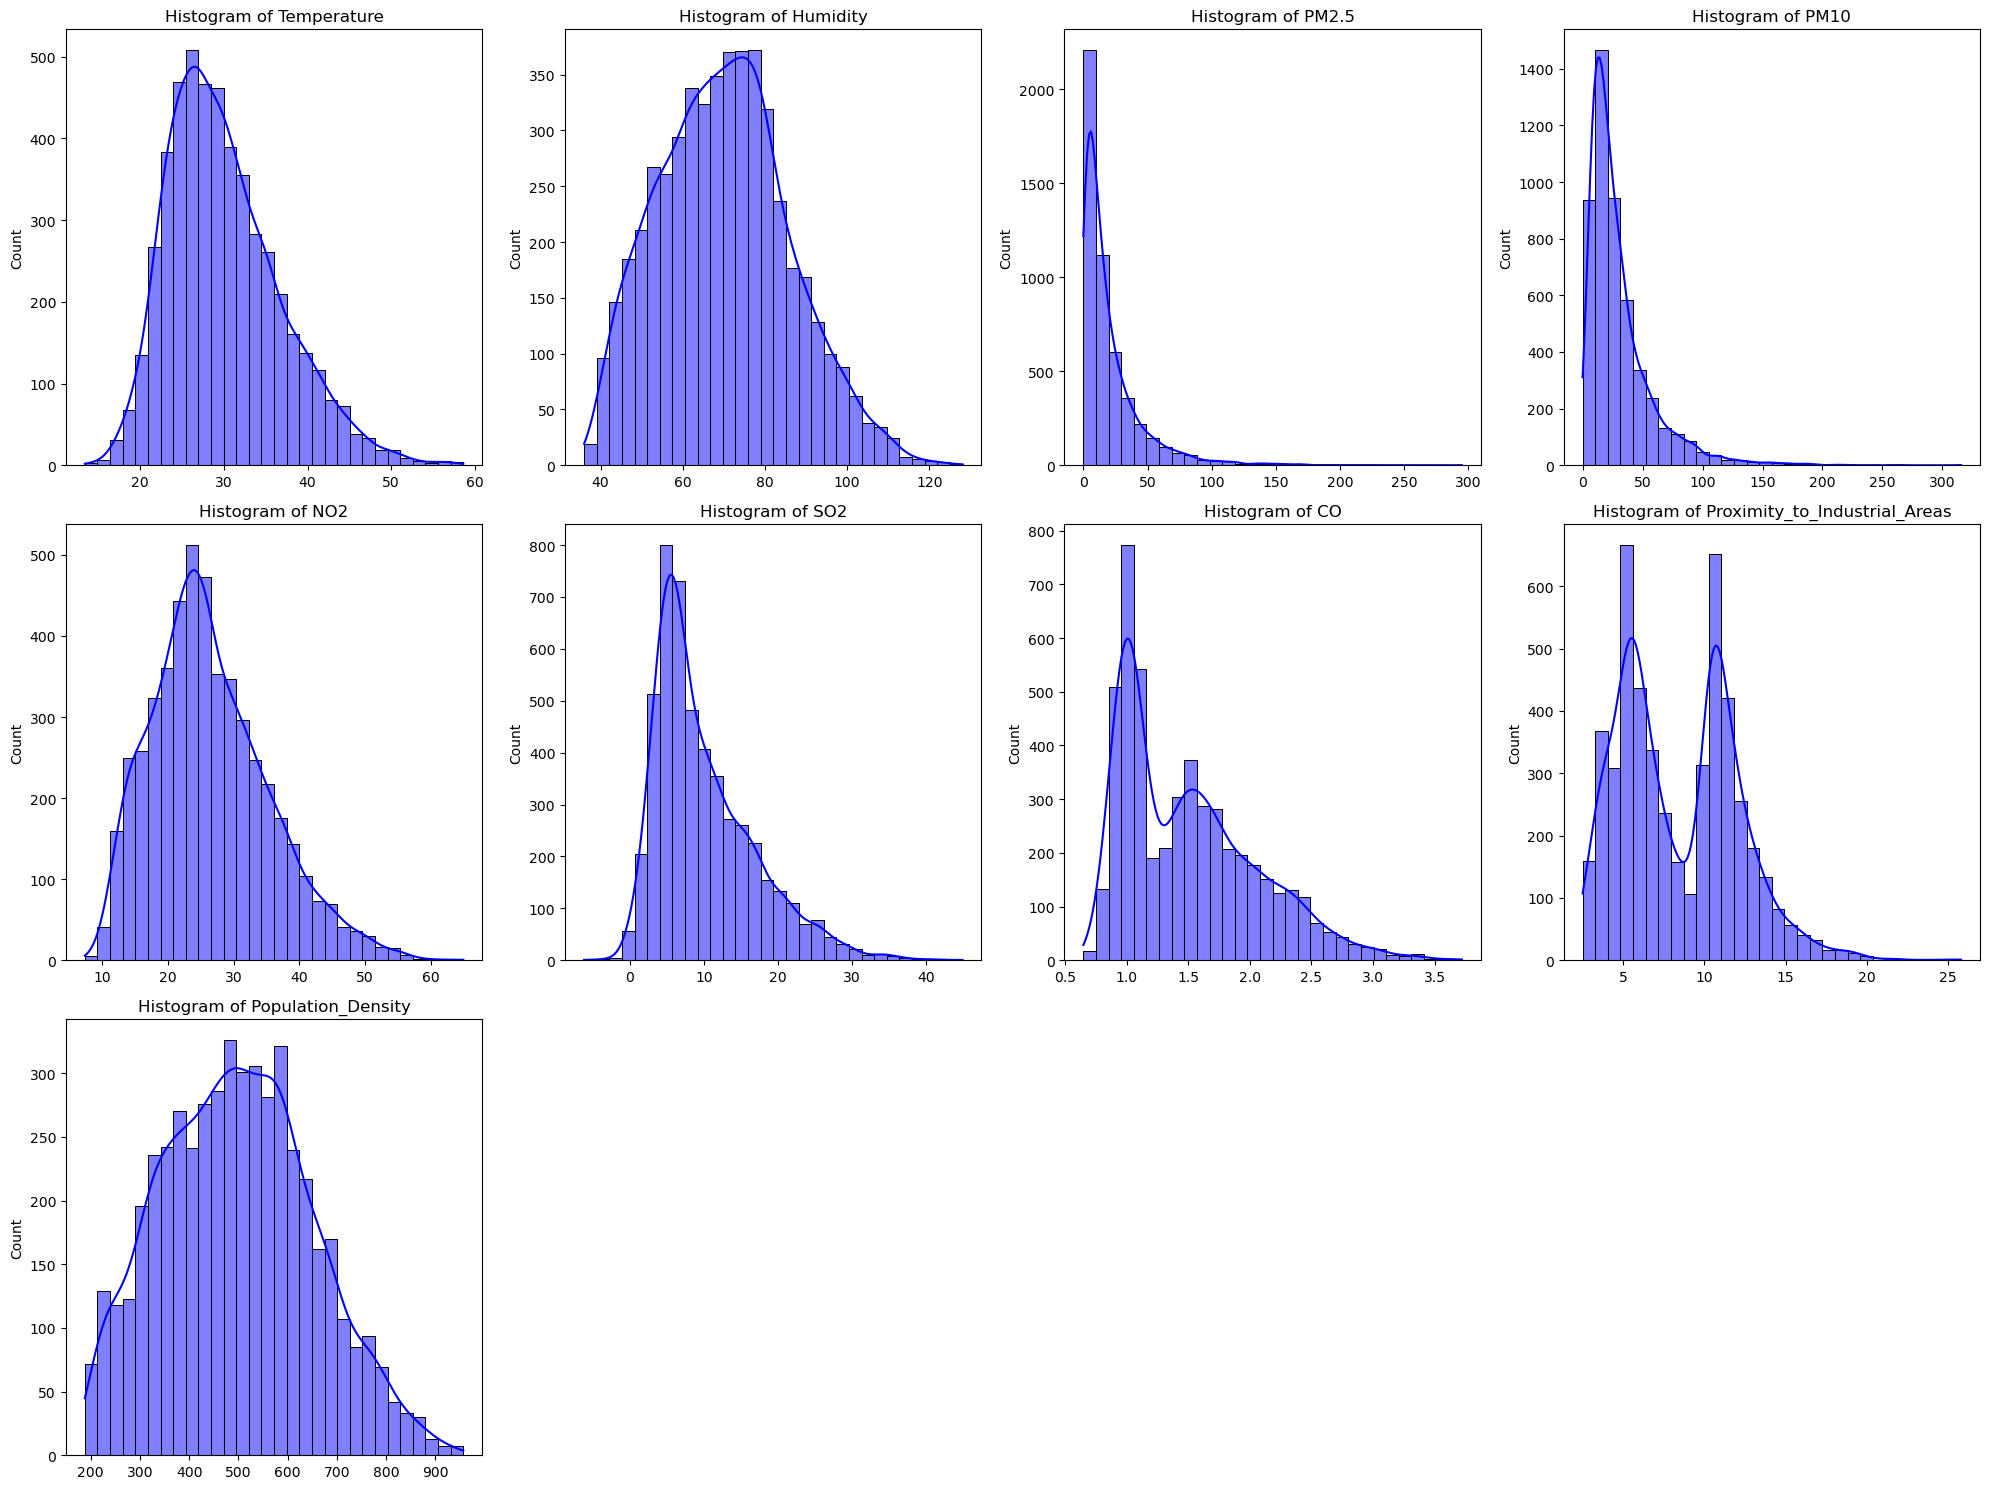

In [50]:
# let's first check the distribution of the data
plot_histograms(data)

#### Findings
Temperature :- Shows a fairly normal distribution centered around the 25 <br>
Humidity :- Shows a fairly normal distribution centered around the 70 - 80 <br>
Pm2.5 :- Skewed to the left with a peak between 0-10<br>
Pm10 :- Skewed to the left with a peak at 20<br>
NO2 :- Shows a normal distrubution centered around 20-30<br>
SO2 :- skewed to the left with a peak between 3-7<br>
CO :- skewed to the left with a peak at 1<br>
Proximity_to_Industrial_Areas :- shows two peaks <br>
Population_Density :- shows a normal distribution centered around 450-550<br>

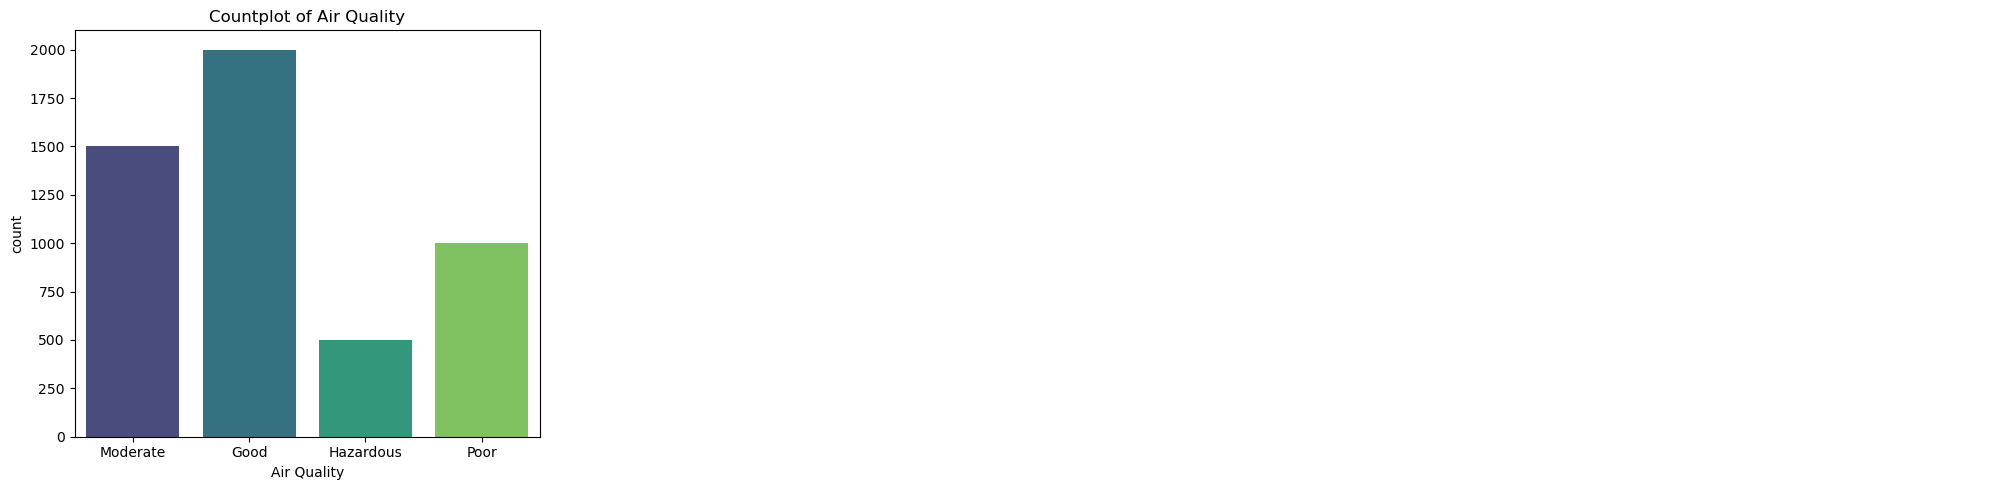

In [51]:
plot_categorical(data)

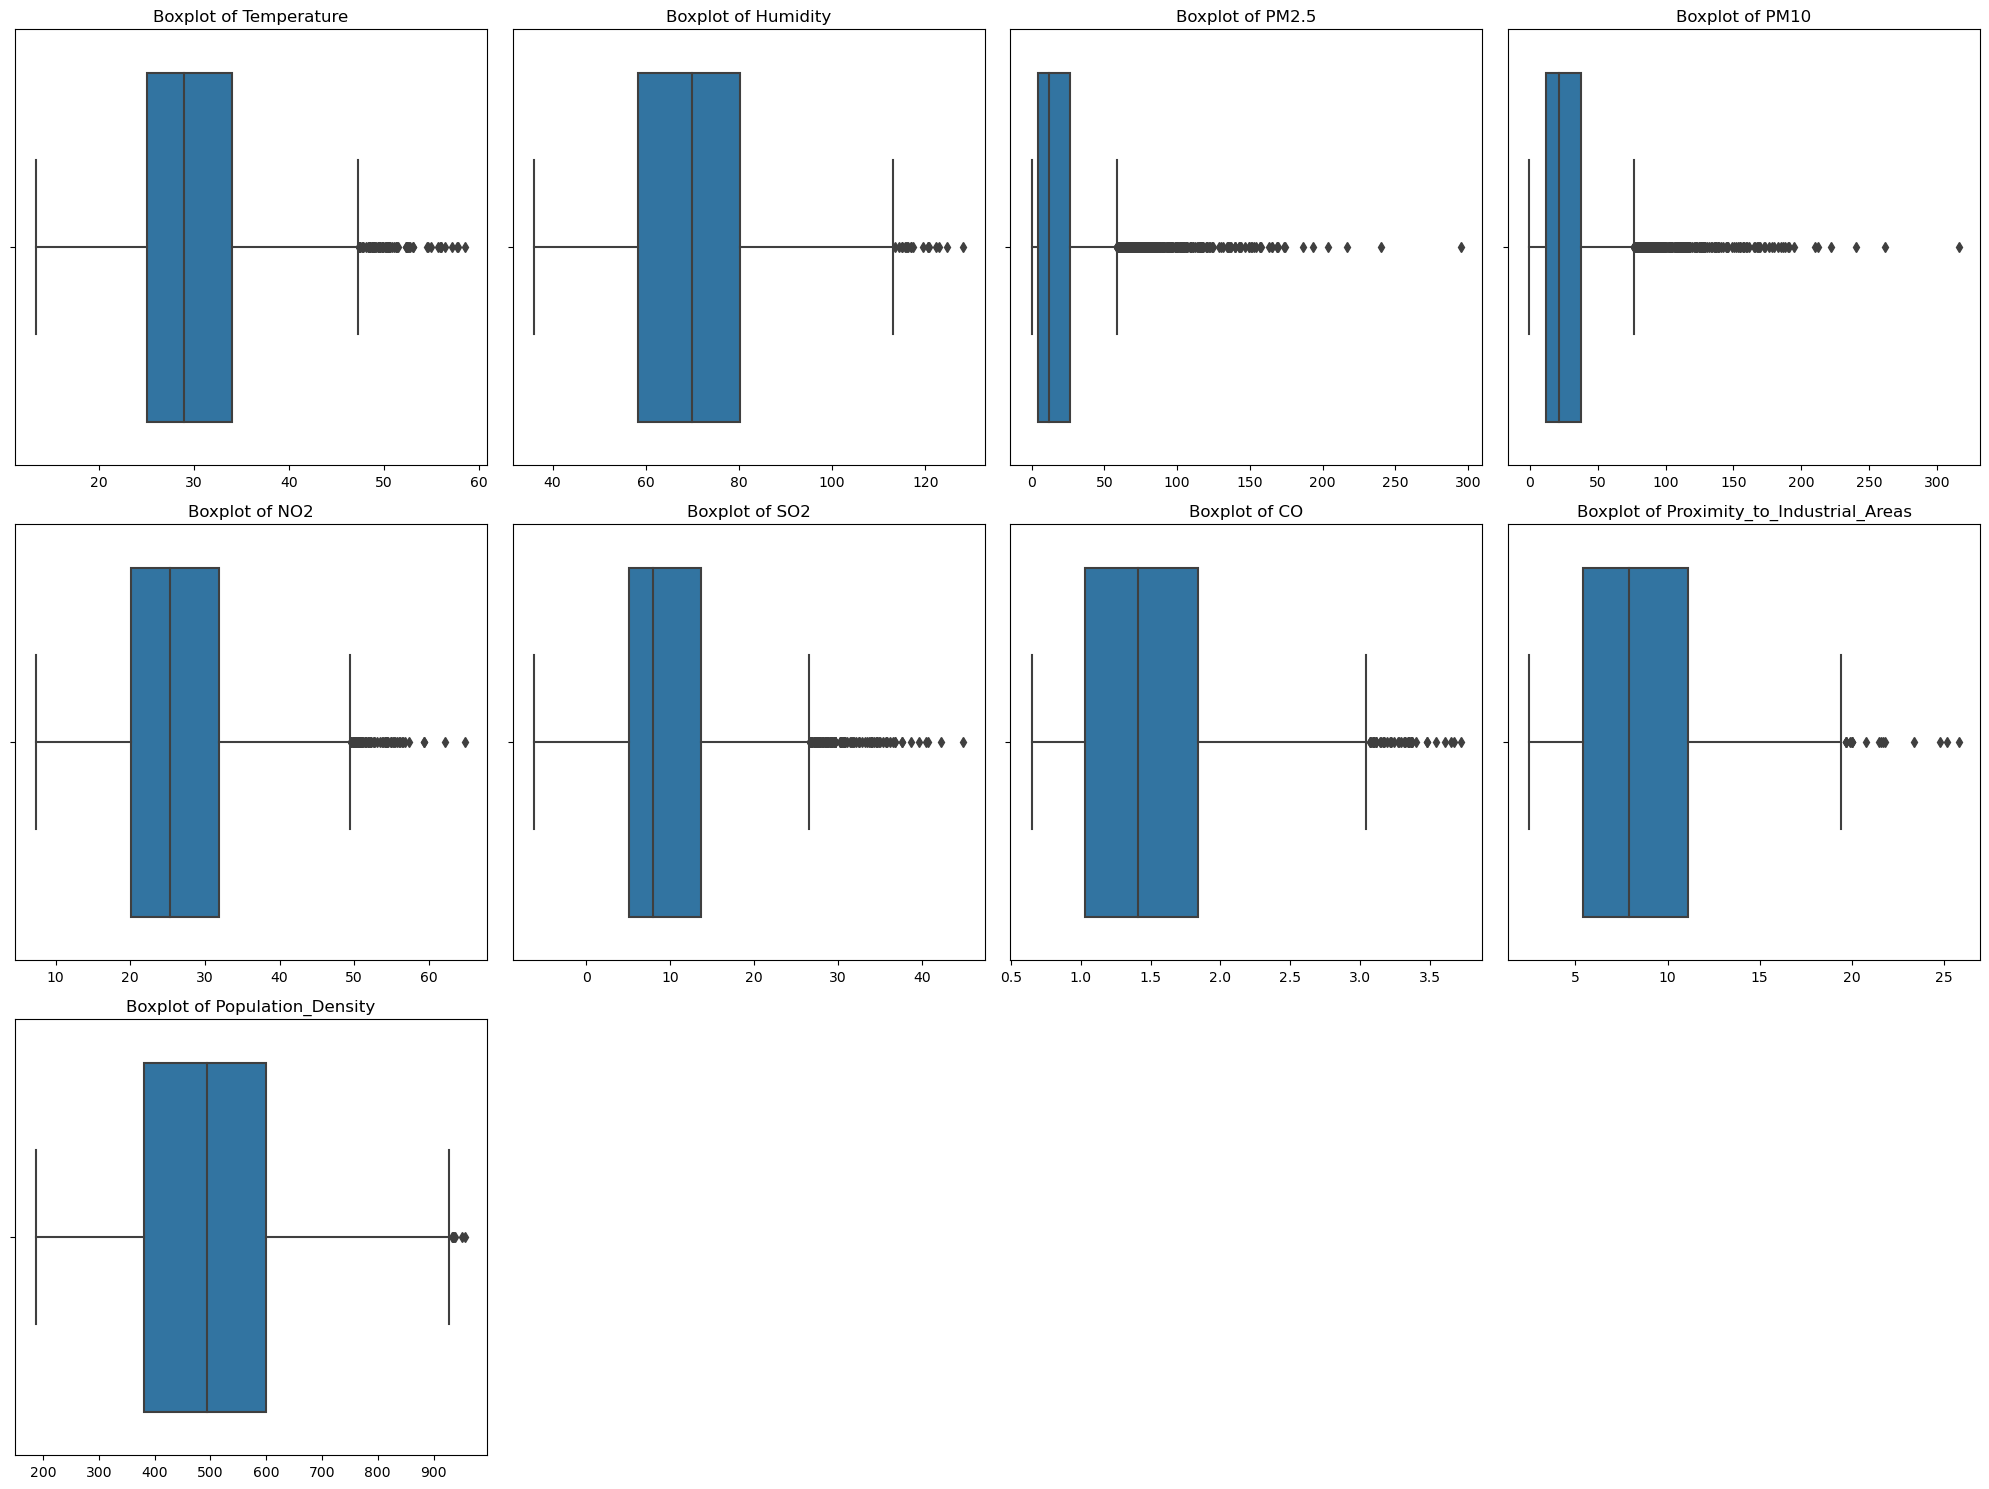

In [52]:
plot_outliers(data)

#### findings :- Every feature has outliers. To handle outliers, we replace them with the mean value of the column where the outlier is detected.

In [54]:
clean_data = remove_outliers(data)

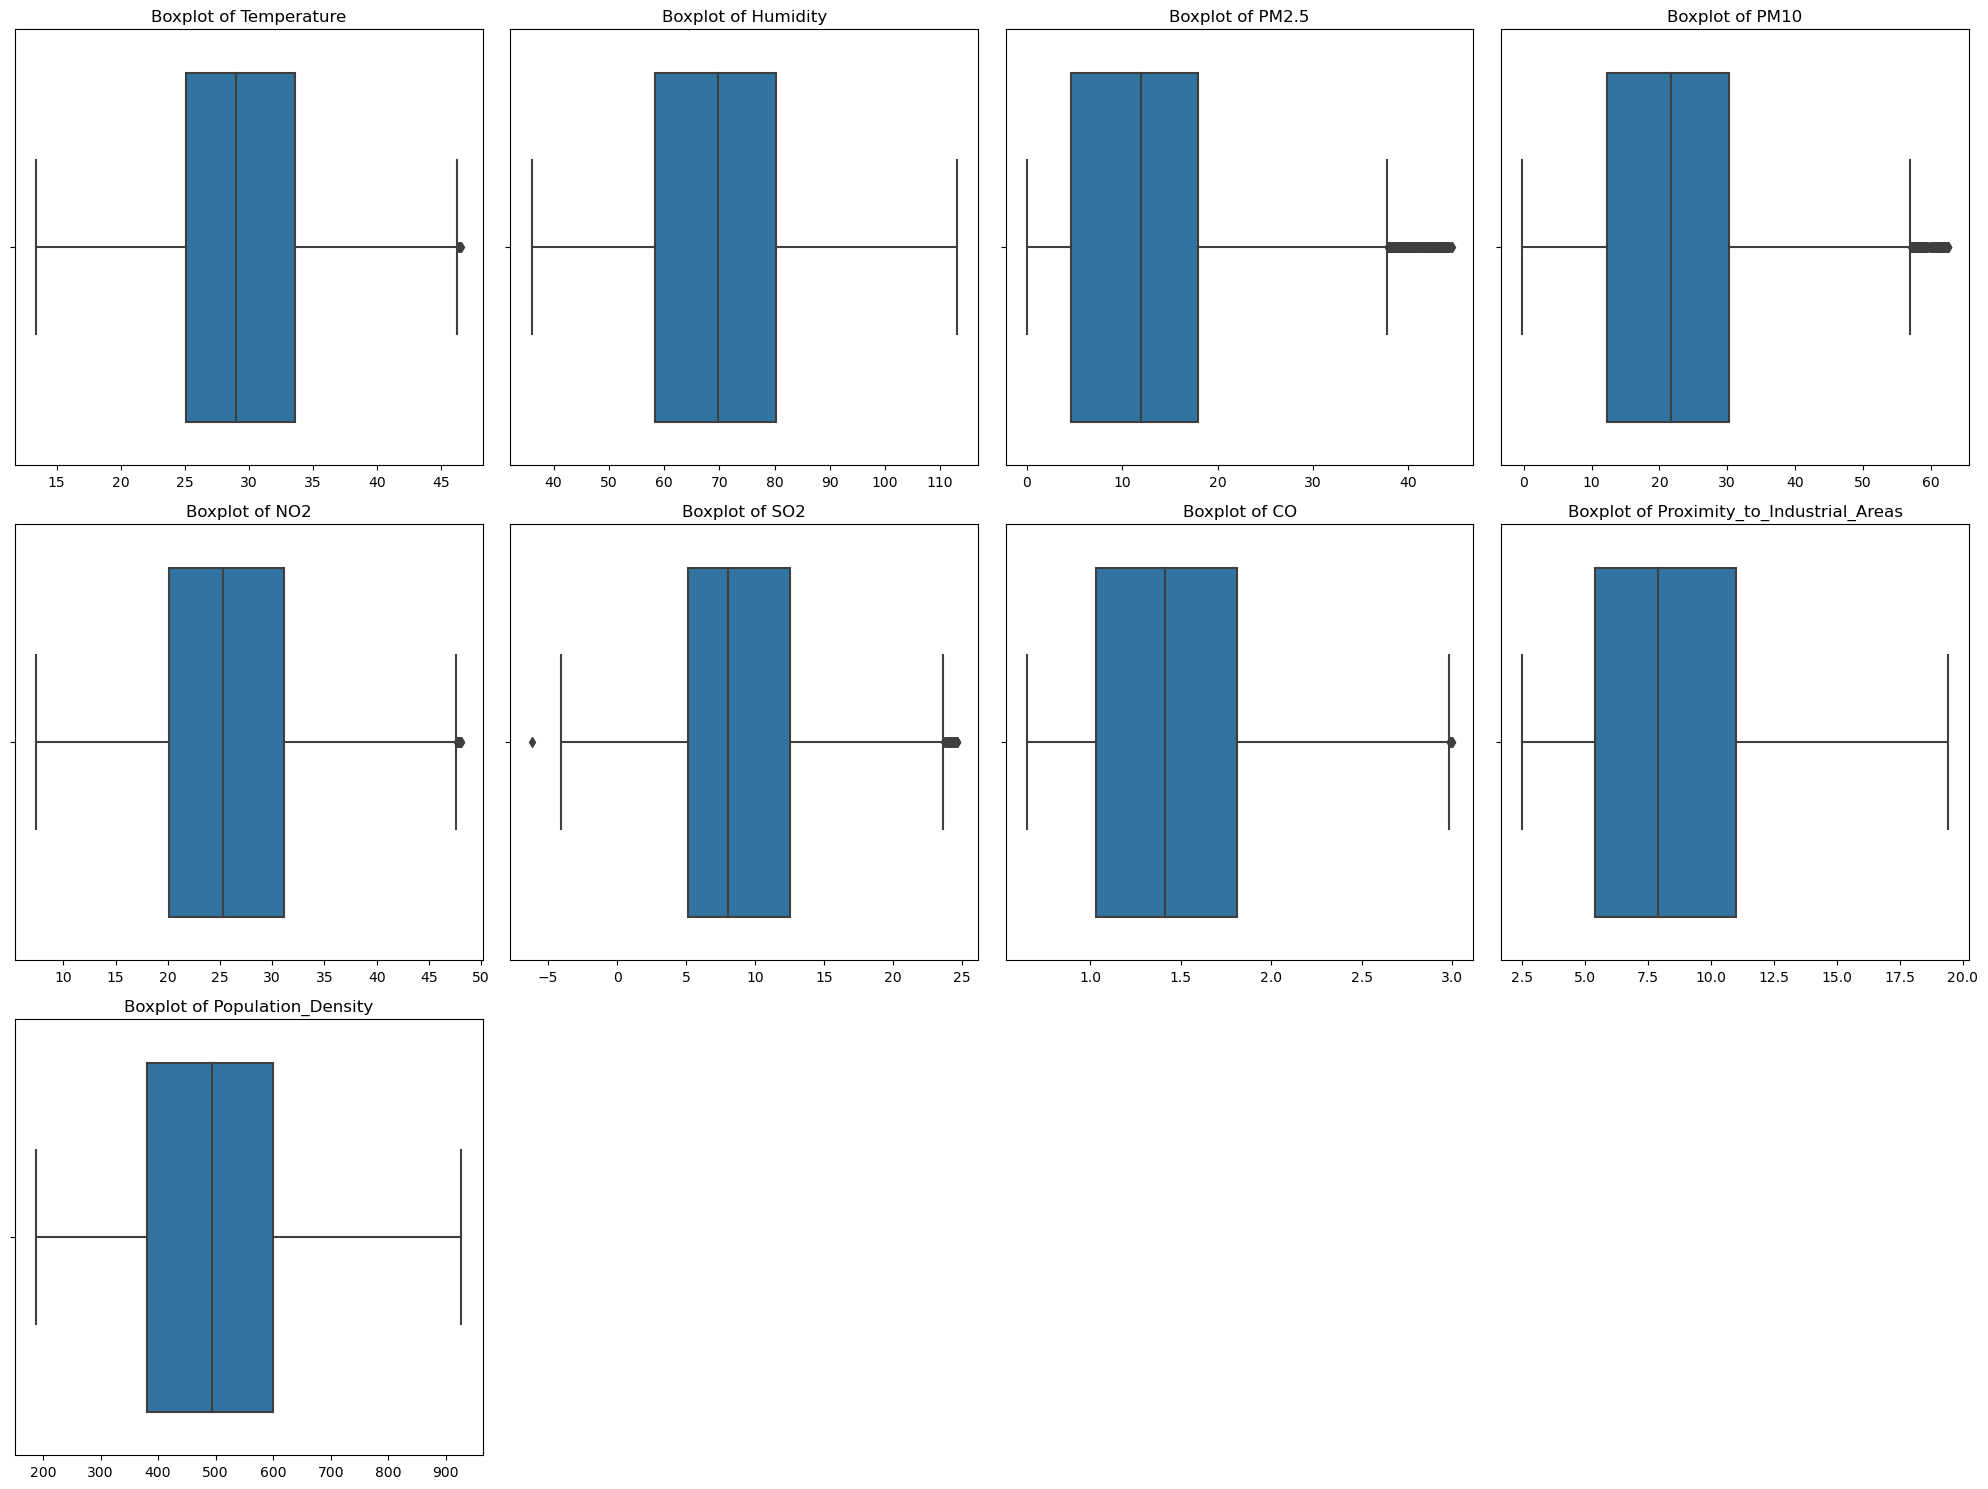

In [55]:
plot_outliers(clean_data)

C:\Users\swapn\AppData\Local\Temp\ipykernel_20684\2299519518.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = clean_data.corr()


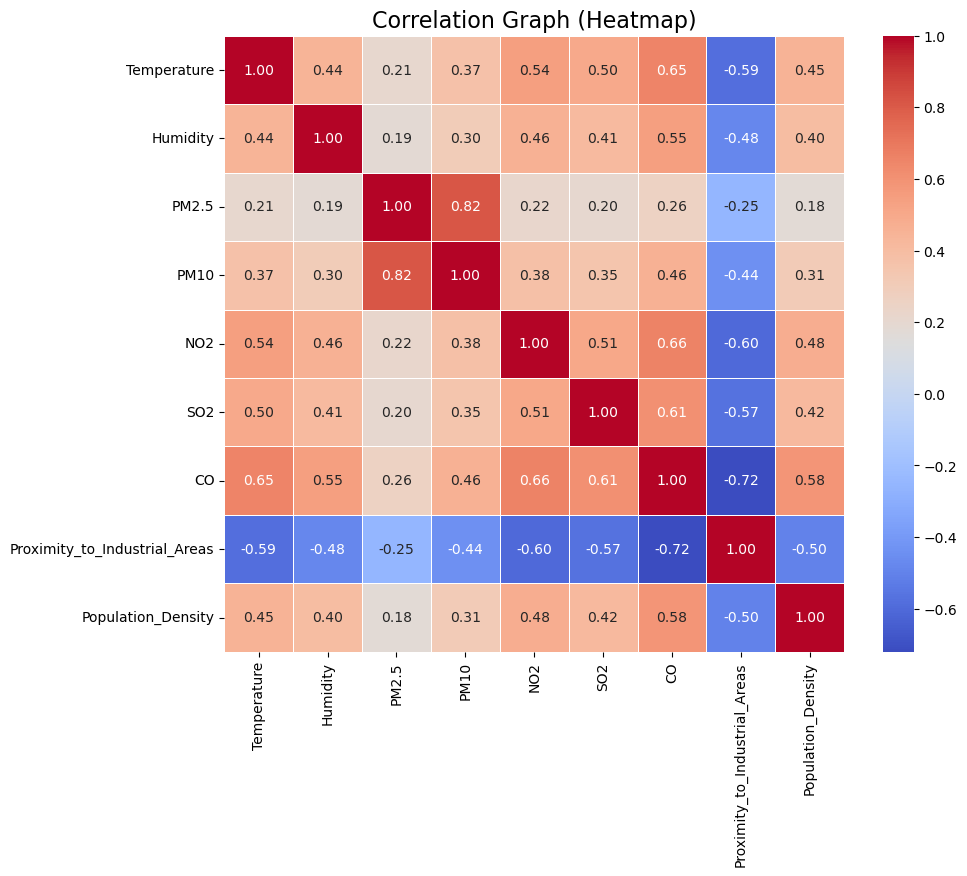

In [56]:
# Now let's check for the correlation matrix
correlation_matrix = clean_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Graph (Heatmap)', fontsize=16)
plt.show()

#### Findings :- Strong positive relation between PM2.5 and PM10. And Proximity feature has negative correlation with most of the columns 
We can further perform bivariate analysis to understand the relationship between the features and the target variable. But, we skip this.

### 4. Data preprocessing (train-test split, scaling, encoding)

In [58]:
X = clean_data.drop("Air Quality", axis=1)
y = clean_data["Air Quality"].values

In [ ]:
# We use label encoder to encode categorical values into numerical values
label_enc = LabelEncoder()

y_enc = label_enc.fit_transform(y)

In [66]:
np.unique(y_enc)

array([0, 1, 2, 3])

In [67]:
# Scale the data with standard Scaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [68]:
# splitting the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_enc, shuffle=True, stratify=y_enc, random_state=42)
print(X_train.shape, y_train.shape)

(3750, 9) (3750,)


### 5. Multiple Model building (Logistic Regression, KNN, Decision Tree, Random Forest, SVC)

#### Cross Validation : CV estimate the model's performance on unseen data without touching the test dataset. It splits the training dataset into multiple folds. The mean and standard deviation of the cross validation results tells how well the model is likely to perform on unseen data.

In [ ]:
logistic_model = LogisticRegression(multi_class='multinomial')
model_mean, model_std = perform_cv(10, logistic_model, X_train, y_train)
print(f"Logistic Model - mean : {model_mean}, std : {model_std}")


Logistic Model - mean : 0.9069333333333333, std : 0.012646299414804664


In [80]:
knn = KNeighborsClassifier(n_neighbors=10)
model_mean, model_std = perform_cv(10, knn, X_train, y_train)
print(f"K nearest neighbours - mean : {model_mean}, std : {model_std}")

K nearest neighbours - mean : 0.8906666666666666, std : 0.013172361637577013


In [83]:
dt_model = DecisionTreeClassifier()
model_mean, model_std = perform_cv(10, dt_model, X_train, y_train)
print(f"Decision Tree - mean : {model_mean}, std : {model_std}")

Decision Tree - mean : 0.8984000000000002, std : 0.012589943076387049


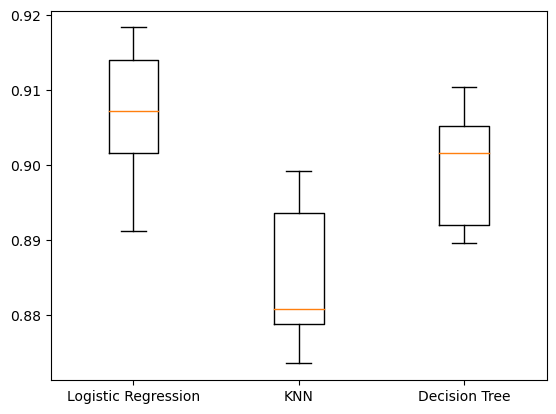

In [85]:
models = {"Logistic Regression": LogisticRegression(), "KNN": KNeighborsClassifier(),  
"Decision Tree": DecisionTreeClassifier()} 
results = []  
for model in models.values(): 
    kf = KFold(n_splits=6, random_state=42, shuffle=True) 
    cv_results = cross_val_score(model, X_train, y_train, cv=kf) 
    results.append(cv_results) 
plt.boxplot(results, labels=models.keys()) 
plt.show() 

#### Once, we find the best model, we can further tune the hyperparameters to improve the model's performance. Then we have to train the model again on the entire training dataset and make predictions on the test dataset.

In [87]:
# in this case we see logistic regression performs best
# Final training on the entire training set
logistic_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = logistic_model.predict(X_test)

test_acc = accuracy_score(y_test, y_pred)
print(test_acc)

0.8944


#### GridSearchCV : It is used for hyperparameter tunining. It systematically tests different combinations of specified hyperparameters to improve the model's performance and selects the combination that yields the best results.

In [106]:
models = {"Logistic Regression": LogisticRegression(), 
          "KNN": KNeighborsClassifier(),  
            "Decision Tree": DecisionTreeClassifier(), 
            "SVC": SVC(), 
            "Random Forest" : RandomForestClassifier()} 

# hyper parameters for which we have to evaluate model's performance
dt_param_grid = {"min_samples_split" : range(10,500,20),
                "max_depth": range(1,20,2)}

svc_param_grid = {"kernel" : ["rbf"],
                 "gamma": [0.001, 0.01, 0.1, 1],
                 "C": [1,10,50,100,200,300,1000],
                 "probability":[True]}

rf_param_grid = {"max_features": [1,3,10],
                "min_samples_split":[2,3,10],
                "min_samples_leaf":[1,3,10],
                "bootstrap":[False],
                "n_estimators":[100,300],
                "criterion":["gini"]}

logreg_param_grid = {"C":np.logspace(-3,3,7),
                    "penalty": ["l1","l2"],
                    "solver": ['liblinear', 'lbfgs']}

knn_param_grid = {"n_neighbors": np.linspace(1,19,10, dtype = int).tolist(),
                 "weights": ["uniform","distance"],
                 "metric":["euclidean","manhattan"]}

In [107]:
models_param = [logreg_param_grid, knn_param_grid, dt_param_grid, svc_param_grid, rf_param_grid]

cv_results = []
best_estimator = []

In [110]:
# Model training

# for index, model in enumerate(models.values()):
for (model_name, model), params in zip(models.items(), models_param):
    
    # print(model, models_param[index])
    gridsearch_cv = GridSearchCV(estimator=model, 
                                    param_grid=params, 
                                    cv=StratifiedKFold(n_splits=10), 
                                    scoring="accuracy")
    gridsearch_cv.fit(X_train, y_train)
    
    print(f"Best estimator - {gridsearch_cv.best_estimator_}")
    cv_results.append(gridsearch_cv.best_score_)
    best_estimator.append(gridsearch_cv.best_estimator_)
    

c:\Users\swapn\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\swapn\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best estimator - LogisticRegression(C=10.0)
Best estimator - KNeighborsClassifier(metric='manhattan', n_neighbors=11, weights='distance')
Best estimator - DecisionTreeClassifier(max_depth=9, min_samples_split=30)
Best estimator - SVC(C=50, gamma=0.01, probability=True)
Best estimator - RandomForestClassifier(bootstrap=False, max_features=3, min_samples_split=3)


In [113]:
print(cv_results)
print(best_estimator)

[0.9098666666666666, 0.9098666666666666, 0.9098666666666666, 0.9034666666666669, 0.9189333333333332, 0.9213333333333333, 0.9416]
[LogisticRegression(C=10.0), LogisticRegression(C=10.0), LogisticRegression(C=10.0), KNeighborsClassifier(metric='manhattan', n_neighbors=11, weights='distance'), DecisionTreeClassifier(max_depth=9, min_samples_split=30), SVC(C=50, gamma=0.01, probability=True), RandomForestClassifier(bootstrap=False, max_features=3, min_samples_split=3)]


In [114]:
# Now we train the Random Forest model using entire training data and parameters that yield the highest accuracy value.

# model performs best
model = best_estimator[-1]

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

### 6. Model Evaluation

In [115]:
# Let's calculate the accuracy and other relevant metrics
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy of the best model is {acc}")

Accuracy of the best model is 0.9432


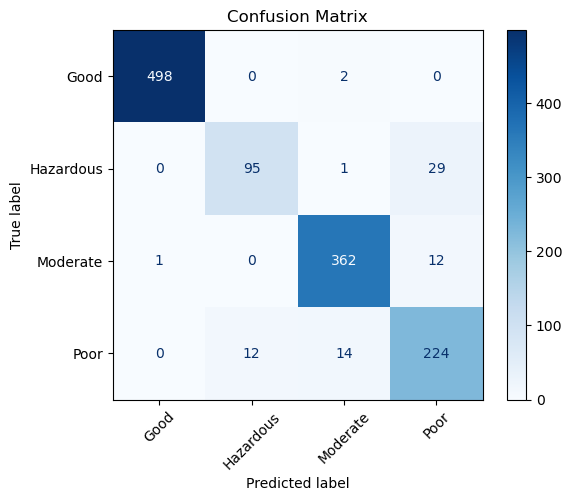

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       0.89      0.76      0.82       125
           2       0.96      0.97      0.96       375
           3       0.85      0.90      0.87       250

    accuracy                           0.94      1250
   macro avg       0.92      0.90      0.91      1250
weighted avg       0.94      0.94      0.94      1250



In [116]:
# confusion matrix and classification report
confusion_matrix = confusion_matrix(y_test, y_pred)

labels = ["Good", "Hazardous", "Moderate", "Poor"]
fig = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
fig.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred))

#### Conclusion : SVC is the best model with an accuracy of 0.85, precision of 0.85, recall of 0.85 and f1-score of 0.85.